## Sección de Librerías

In [1]:
#Básicos para manipulacion de datos 
import pandas as pd
import numpy as np
#Graficas 
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
sns.set_theme()
#Optimización multiobjetivo 
from pymoo.util.ref_dirs import get_reference_directions
from pymoo.optimize import minimize
from pymoo.core.population import Population

#Finanzas 
import yfinance as yf
import yesg

#Plugins
from tqdm import tqdm
from itertools import compress
from Plugins import pre_processing
from Plugins import ArchievingStrategies
from Plugins import my_plotting
from Plugins import pymoo_extras
from Plugins import DS

## Descarga de lista de activos a escoger
Esta sección puede dar errores si se pierde la conexión, solo es necesario volver a ejecutar. 

In [2]:
assets = pd.read_csv('Indices/tickers_nasdaq100.csv', index_col=0)['0'].tolist()

## Primera parte, obtención de los activos para el portafolio

In [3]:
ohlc = yf.download(assets, period="2y") 
prices = ohlc["Adj Close"].dropna(how="all")

[*********************100%***********************]  94 of 94 completed


In [4]:
prices.tail()

ABNB        ADBE         ADI        ADSK        AEP  \
Date                                                                    
2023-06-27  127.889999  489.269989  192.380005  206.850006  83.440002   
2023-06-28  127.629997  482.429993  189.899994  206.300003  81.620003   
2023-06-29  125.099998  483.769989  189.479996  206.179993  83.260002   
2023-06-30  128.160004  488.989990  194.809998  204.610001  84.199997   
2023-07-03  132.350006  485.209991  194.330002  203.699997  85.320000   

                  ALGN        AMAT         AMD        AMGN        ANSS  ...  \
Date                                                                    ...   
2023-06-27  340.690002  146.550003  110.389999  222.610001  323.320007  ...   
2023-06-28  345.070007  144.029999  110.169998  221.309998  324.309998  ...   
2023-06-29  341.790009  144.229996  111.239998  221.160004  326.049988  ...   
2023-06-30  353.640015  144.539993  113.910004  222.020004  330.269989  ...   
2023-07-03  344.589996  145.470001  115.820000  225.009995  326.950012  ...   

                  TMUS         TXN        VRSK        VRTX        WBA    WBD  \
Date                                                                           
2023-06-27  136.169998  176.309998  224.630005  347.119995  28.639999  12.27   
2023-06-28  136.270004  174.960007  223.169998  350.779999  29.080000  12.45   
2023-06-29  136.839996  176.789993  223.270004  348.179993  28.370001  12.42   
2023-06-30  138.899994  180.020004  226.029999  351.910004  28.490000  12.54   
2023-07-03  139.330002  179.759995  222.500000  347.570007  29.020000  13.01   

                  WDAY        XEL         ZM          ZS  
Date                                                      
2023-06-27  224.220001  62.439999  68.050003  144.660004  
2023-06-28  222.960007  61.240002  68.690002  144.110001  
2023-06-29  227.119995  61.290001  67.599998  144.839996  
2023-06-30  225.889999  62.169998  67.879997  146.300003  
2023-07-03  224.589996  62.980000  68.290001  146.589996  

[5 rows x 94 columns]

In [5]:
returns, assets_info= pre_processing.get_assets_info(prices, 99, log_returns=True, drop_per_esg=True)
assets_info #Los rendimientos están con signo al revés 

100%|██████████| 91/91 [00:20<00:00,  4.50it/s]


exp_risk  exp_return  esg_score
NXPI  0.401035   -0.031586      0.216
NFLX  0.576277    0.102892      0.163
MU    0.427748    0.113643      0.174
MSFT  0.304332   -0.107827      0.152
MRVL  0.582605   -0.037303      0.201
...        ...         ...        ...
DLTR  0.393947   -0.199938      0.149
CTSH  0.296658    0.008450      0.144
CTAS  0.241646   -0.131640      0.183
CSX   0.254573   -0.041793      0.201
CSGP  0.363089   -0.023112      0.269

[70 rows x 3 columns]

In [6]:
best_assets = ArchievingStrategies.get_best_opt(assets_info.iloc[:, :2], 1e-6)
best_assets

70it [00:00, 13993.01it/s]


exp_risk  exp_return
ON    0.532355   -0.467451
ORLY  0.251712   -0.246490
VRTX  0.276777   -0.277853
PEP   0.167895   -0.137036
PCAR  0.250593   -0.223047
AVGO  0.329377   -0.339018
EXC   0.221877   -0.157118

In [7]:
fig = my_plotting.plot_assets_plotly(assets_info, best_assets, with_labels=False)
fig.show()

## Segunda Parte, Definición del Problema

In [8]:
PROFITS, RISK, ESG_SCORES = pre_processing.get_final_assets(returns[best_assets.index], assets_info.loc[best_assets.index])
portfolio_problem = pymoo_extras.Portfolio_Problem(len(PROFITS), PROFITS, RISK, ESG_SCORES)

In [9]:
from finquant import efficient_frontier
ef = efficient_frontier.EfficientFrontier(pd.Series(PROFITS), pd.DataFrame(RISK), freq=252)
ef_R = ef.efficient_frontier()

## Tercera parte, utilizar distintos muestreos

In [10]:
eps = np.array([0.01,0.01])
colors = ['rgb(141,160,203)', 'rgb(27,158, 119)']

### Markowitz Directed-Search

In [11]:
#Primer paso generar la población eficiente 
def get_Markowitz_directions(size, steps): 
    X_ef = DS.efficient_frontier_weights(ef, size)
    F_ef, ESG_ef = pymoo_extras.eval_weights(portfolio_problem, X_ef)
    FA_ef =  pymoo_extras.annualised_portfolio_quantities(F_ef)
    FA_ef_best = ArchievingStrategies.get_best_opt(FA_ef, 1e-6)
    X_ef= X_ef[FA_ef_best.index]
    ds = DS.DirectedSearch(X_ef[:], PROFITS, RISK, eps, learn_rate=0.001, n_iter=1000)
    X_ef_new = ds.directed_search_full_space(steps)
    return X_ef_new[:]

In [12]:
X_ef = get_Markowitz_directions(1000, 15)
F_ef, ESG_ef = pymoo_extras.eval_weights(portfolio_problem, X_ef)
FA_ef =  pymoo_extras.annualised_portfolio_quantities(F_ef)
FA_ef_best = ArchievingStrategies.get_best_opt(FA_ef, 1e-6)
FA_ef_best_eps = ArchievingStrategies.get_best_opt_eps(FA_ef, 1e-6, eps)
print('Total', FA_ef.shape)
print('Mejores', FA_ef_best.shape)
print('Eps-Mejores', FA_ef_best_eps.shape)

1000it [00:00, 5714.09it/s]
13245it [00:09, 1352.07it/s]
13245it [00:33, 392.08it/s]

Total (13245, 2)
Mejores (7122, 2)
Eps-Mejores (13245, 2)


In [13]:
frames = [ FA_ef_best_eps, FA_ef_best]
labels = [ 'PQ-eps', 'PQ']
fig = my_plotting.plotting_samples_plotly(ef_R, frames, labels, colors)
fig.show()

### Con pesos uniformes

In [14]:
X_das = get_reference_directions("das-dennis", len(PROFITS), n_partitions=10)
F_das, ESG_das = pymoo_extras.eval_weights(portfolio_problem, X_das)
FA_das =  pymoo_extras.annualised_portfolio_quantities(F_das)
FA_das_best = ArchievingStrategies.get_best_opt(FA_das, 1e-6)
FA_das_best_eps = ArchievingStrategies.get_best_opt_eps(FA_das, 1e-6, eps)
print('Total', FA_das.shape)
print('Mejores', FA_das_best.shape)
print('Eps-Mejores', FA_das_best_eps.shape)


8008it [00:01, 5668.97it/s]
8008it [00:05, 1538.61it/s]

Total (8008, 2)
Mejores (134, 2)
Eps-Mejores (3454, 2)


In [15]:
frames = [FA_das_best_eps, FA_das_best]
labels = ['PQ-eps', 'PQ']
fig = my_plotting.plotting_samples_plotly(ef_R, frames, labels, colors)
fig.show()

### Con Algoritmos Evolutivos

In [16]:
from pymoo.termination import get_termination
termination = get_termination("n_gen", 300)
from pymoo.algorithms.moo.nsga2 import NSGA2
nsgaii = NSGA2(pop_size=40,repair=pymoo_extras.Portfolio_Repair())
from pymoo.algorithms.moo.sms import SMSEMOA
smsemoa = SMSEMOA(pop_size=40, repair=pymoo_extras.Portfolio_Repair())

#### Con NSGA-II

In [17]:
X_nsgaii, F_nsgaii, ESG_nsgaii =pymoo_extras.get_weights_with_pymoo(portfolio_problem, nsgaii, termination)
FA_nsgaii =  pymoo_extras.annualised_portfolio_quantities(F_nsgaii)
FA_nsgaii_best = ArchievingStrategies.get_best_opt(FA_nsgaii, 1e-6)
FA_nsgaii_best_eps = ArchievingStrategies.get_best_opt_eps(FA_nsgaii, 1e-6, eps)
print('Total', FA_nsgaii.shape)
print('Mejores', FA_nsgaii_best.shape)
print('Eps-Mejores', FA_nsgaii_best_eps.shape)

12000it [00:02, 5602.18it/s]
12000it [00:27, 444.18it/s]

Total (12000, 2)
Mejores (879, 2)
Eps-Mejores (11042, 2)


In [18]:
frames = [FA_nsgaii_best_eps, FA_nsgaii_best]
labels = ['PQ-eps', 'PQ']
fig=my_plotting.plotting_samples_plotly(ef_R, frames, labels, colors)
fig.show()

#### Con SMS-EMOA

In [19]:
X_smsemoa, F_smsemoa, ESG_smsemoa =pymoo_extras.get_weights_with_pymoo(portfolio_problem, smsemoa, termination)
FA_smsemoa =  pymoo_extras.annualised_portfolio_quantities(F_smsemoa)
FA_smsemoa_best = ArchievingStrategies.get_best_opt(FA_smsemoa, 1e-6)
FA_smsemoa_best_eps = ArchievingStrategies.get_best_opt_eps(FA_smsemoa, 1e-6, eps)
print('Total', FA_smsemoa.shape)
print('Mejores', FA_smsemoa_best.shape)
print('Eps-Mejores', FA_smsemoa_best_eps.shape)

12000it [00:03, 3554.43it/s]
12000it [00:31, 380.00it/s]

Total (12000, 2)
Mejores (2143, 2)
Eps-Mejores (11338, 2)


In [20]:
frames = [FA_smsemoa_best_eps, FA_smsemoa_best]
labels = ['PQ-eps', 'PQ']
fig=my_plotting.plotting_samples_plotly(ef_R, frames, labels, colors)
fig.show()

## Evaluación 

In [21]:
from pymoo.indicators.hv import HV
from pymoo.indicators.igd import IGD
from pymoo.indicators.gd import GD
from sklearn.preprocessing import MinMaxScaler
def get_pfa(name,  fun): 
    if name[0]=='*':
        X_ = fun()
        print(X_.shape)
        F_, ESG_ = pymoo_extras.eval_weights(portfolio_problem, X_)
    else: 
        X_, F_, ESG_ =pymoo_extras.get_weights_with_pymoo(portfolio_problem, fun, termination)
    FA_ = pymoo_extras.annualised_portfolio_quantities(F_)
    #FA_best = ArchievingStrategies.get_best_opt(FA_, 1e-6)
    FA_best_eps = ArchievingStrategies.get_best_opt_eps(FA_, 1e-6, eps)
    return FA_best_eps.to_numpy()

def invert_sign(list_pfa): 
    L = []
    for s in list_pfa:
        s1 = s.copy()
        s1[:, 1] = -s1[:,1]
        L.append(s1)   
    return L  

def eval_GD(pf, list_pfa):  
    ind = GD(pf)
    list_p = invert_sign(list_pfa)
    return [ind(A) for A in list_p]   

def eval_IGD(pf, list_pfa): 
    ind = IGD(pf)
    list_p = invert_sign(list_pfa)
    return [ind(A) for A in list_p]  

def eval_HV(ref_point, list_pfa): 
    scaler = MinMaxScaler()
    Ftest = np.vstack(list_pfa)
    scaler.fit(Ftest)
    ind = HV(ref_point=ref_point)
    return [ind(scaler.transform(A)) for A in list_pfa]

algs = {'*Markowitz' : lambda : get_Markowitz_directions(1000, 15), 
        '*das-dennis': lambda : get_reference_directions("das-dennis", len(PROFITS), n_partitions=10), 
        'nsgaii': nsgaii, 
        'sms-emoa':smsemoa}

def full_evaluation(iters, algs, pf, ref_point):
    metric_eval = {'GD': [], 'IGD': [], 'HV': []}
    metrics = {'GD': lambda x: eval_GD(pf, x), 
               'IGD':lambda x: eval_IGD(pf, x), 
               'HV': lambda x: eval_HV(ref_point, x)}
    for i in range(iters): 
        results = [ get_pfa(name, par) for name, par in algs.items()]
        for indicator in metrics.keys(): 
            metric_eval[indicator].append(metrics[indicator](results[:]))
    
    metric_eval_means = {}
    for indicator in metric_eval.keys(): 
        metric_eval_means[indicator+'mean']=np.mean( np.array(metric_eval[indicator]), axis=0)
        metric_eval_means[indicator+'std'] = np.std( np.array(metric_eval[indicator]), axis=0)
    
    return pd.DataFrame(metric_eval_means, index = algs.keys())

In [22]:
#evaluation = full_evaluation(20, algs, ef_R, np.array([1.1,1.1]))
#evaluation

## Gráficas de Interés Muestreo Ganador

In [23]:
X = get_Markowitz_directions(1000, 15)
F, ESG = pymoo_extras.eval_weights(portfolio_problem, X_ef)
FA =  pymoo_extras.annualised_portfolio_quantities(F)
FA_best = ArchievingStrategies.get_best_opt(FA, 1e-6)
FA_best_eps = ArchievingStrategies.get_best_opt_eps(FA, 1e-6, eps)

FA_3D = FA_best_eps.copy()
FA_3D['exp_esg'] = ESG[FA_best_eps.index]
FA_3D_best       = ArchievingStrategies.get_best_opt(FA_3D, 1e-6)

print('Total', FA.shape)
print('Mejores', FA_best.shape)
print('Eps-Mejores', FA_best_eps.shape)
print('Mejores 3D', FA_3D_best.shape)

1000it [00:00, 4926.15it/s]
13245it [00:09, 1422.12it/s]
13245it [00:30, 432.14it/s]
13245it [00:16, 804.95it/s]

Total (13245, 2)
Mejores (7122, 2)
Eps-Mejores (13245, 2)
Mejores 3D (8874, 3)


In [24]:
frames = [FA, FA_best_eps, FA_best]
labels = ['All (SMS-EMOA)', 'PQ-eps', 'PQ']
colors = ['#7F7F7F', 'rgb(141,160,203)', 'rgb(27,158, 119)']
fig = my_plotting.plotting_samples_plotly(ef_R, frames, labels, colors)
fig.show()

In [25]:
## Correciones de signos 
#En dos objetivos
FA_best['exp_return'] = -FA_best['exp_return']
FA_best['exp_esg'] =  ESG[FA_best.index] 
#En tres objetivos
FA_3D_best['exp_return'] = - FA_3D_best['exp_return']
FA_3D['exp_return'] = - FA_3D['exp_return']
FA_3D['Type'] = 'PQ-eps 2obj'
FA_3D.loc[FA_3D_best.index, 'Type']='PQ 3obj'

In [26]:
fig = my_plotting.plotting_projection_plotly(FA_3D_best, ef_R)
fig.show()

[]

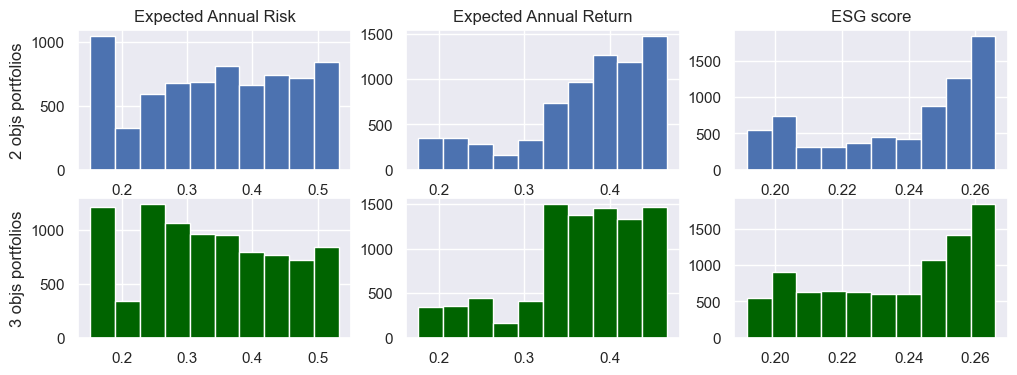

In [27]:
fig = my_plotting.plot_histograms(FA_best, FA_3D_best)
plt.plot()

[]

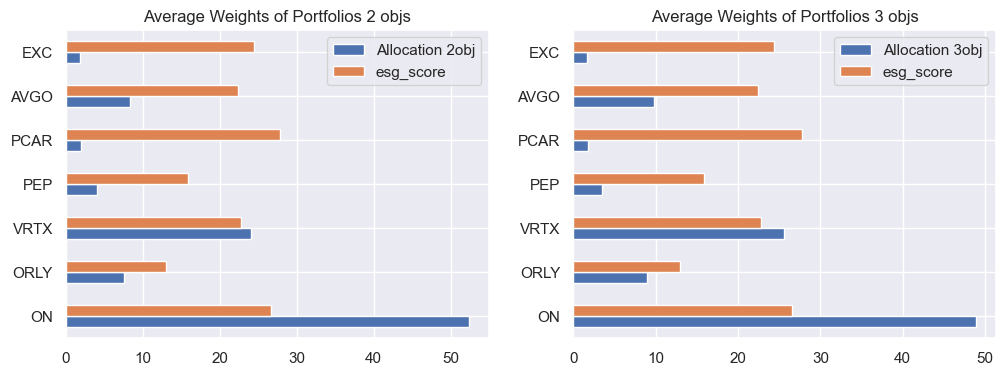

In [28]:
fig = my_plotting.plot_proportions(FA_best, FA_3D_best, X,best_assets, assets_info)
plt.plot()
